In [3]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt


#import data
data = np.loadtxt("arrhythmia.csv", delimiter = ",")

#transpose data, to transverse columns easily 
data = np.transpose(data)

#go to each column, and replace every 1000 with the average value of the non-1000 values in that column
for i in range(len(data)):
    column = data[i]
    numberOfNon1000 = len(column)
    sum = 0
    for j in range(len(column)):
        if (data[i][j] != 1000):
            sum += data[i][j]
        else:
            numberOfNon1000 -=1
    for j in range(len(column)):
        if (data[i][j] == 1000):
            data[i][j] = sum / numberOfNon1000

#sanity check - are there any 1000s in the data still?
for column in data:
    for i in column:
        if (i == 1000):
            print ("bad")
            
            
#re-transpose data
data = np.transpose(data)

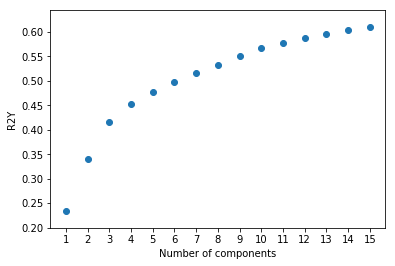

In [4]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score


X = data[:, 0:277]
Y = data[:, 278]

xMean = np.mean(X)
yMean = np.mean(Y)
xSD = np.std(X)
ySD = np.std(Y)

Xnorm = (X - xMean)/xSD
Ynorm = (Y - yMean)/ySD

# Determine R2 scores
r_arr = []
for i in range(1,16):
    pls_i = PLSRegression(n_components = i)
    pls_i.fit(Xnorm, Ynorm)
    Y_predi = pls_i.predict(Xnorm)
    r_arr.append(r2_score(Ynorm , Y_predi))
    
# Plot percent variance 
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.scatter(index,r_arr);
plt.xlabel('Number of components');
plt.ylabel('R2Y');
plt.xticks(index, index);

In [5]:
# Perform leave-one-out cross validation
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

Y_obs = []
Y_pred = []
pls_loo = PLSRegression(n_components = 12)

for train_index, test_index in loo.split(X, Y):    
    pls_loo.fit_transform(X[train_index], Y[train_index])
    pls_loo.transform(X[test_index])
    
    ypred = pls_loo.predict(X[test_index])    
    yobs = Y[test_index]
    
    Y_obs.append(ypred[0,0])
    Y_pred.append(yobs[0]) 
    
r2_loo = r2_score(Y_obs, Y_pred)
print('R2 value: ', r2_loo)  

R2 value:  -0.4380094983834222


In [6]:
#attempting PLS-DA, only trying to distinguish between arrhythmia and no arr
from sklearn import preprocessing as pre

#normalize X data according to how Yi says it should be
X_normal = pre.scale(X)

#make Y matrix of 0s and 1s - 0 = no arr, 1 = some type of arr
Y_binary = []
for i in range(len(Y)):
    if (Y[i] == 1): Y_binary.append(0)
    else: Y_binary.append(1)

#do PLSR
plsda = PLSRegression(n_components = 10)
pc_space = plsda.fit_transform(X_normal, Y_binary)[0]
Y_plsda = plsda.predict(X_normal)

#change predictions from PLS into binary values, and compare to Y_binary
for i in range(len(Y_plsda)):
    if (Y_plsda[i] > 0.5):
        Y_plsda[i] = 1
    else:
        Y_plsda[i] = 0

correct = 0
for i in range(len(Y_binary)):
    if (Y_binary[i] == Y_plsda[i]):
        correct += 1
print ("Percent correctly identified: (no crossvalidation): ", correct / len(Y_binary))


Percent correctly identified: (no crossvalidation):  0.8893805309734514


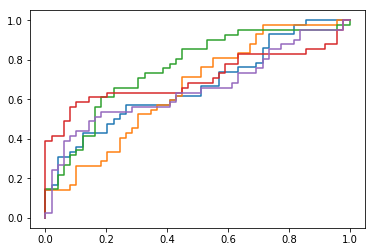

In [18]:
# trying to make an ROC curve with the crossvalidation results
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

Y_binary = np.array(Y_binary)

cv = StratifiedKFold(n_splits = 5)
i = 0 
for train,test in cv.split(X_normal, Y_binary):
    plsda.fit(X_normal[train], Y_binary[train])
    Y_plsda = plsda.predict(X[test])
    fpr, tpr, thresholds = roc_curve(Y_binary[test], Y_plsda)
    plt.plot(fpr,tpr)